### Problem Background

Suppose we have the following function or forward model,

$$G(\mathbf{x},\mathbf{m}) = m_0 e^{m_1\mathbf{x}} + m_2 \mathbf{x} e^{m_3\mathbf{x}}$$

where $\mathbf{x}$ and $\mathbf{m}$ are vectors and the operations are element-wise, as you would expect `numpy` to do on arrays. That is to say, for $N$ length array $\mathbf{x}$, $G$ will have $N$ values. Also assume we have data set $\mathbf{d} = (d_0,d_1,d_2,...)$ that can explained (or 'fit') by this function. We would like to know the values of the parameters $\mathbf{m} = (m_0,m_1,m_2,m_3)$ that best explain the data using the function $G(x,\mathbf{m})$. Further, we would like to know the distribution of those parameters $\mathbf{m}$.

For the purpose of experimentation, let us assume that we know the true values of $\mathbf{m_t}$ are $(1.0,-0.5,1.0,-0.75)$. Further suppose the 'data', $\mathbf{d}$ can be generated by creating a vector $\mathbf{x}$, and evaluating $G(\mathbf{x},\mathbf{m_t})$ and then adding measurement noise in the form of $N(0,\sigma)$. Here the $\mathbf{x}$ should be 25 equally spaced values on the interval [1,7]. The data noise should be characterized by $\sigma = $ 0.01 where $N(0,\sigma)$ is a Gaussian with 0 mean and standard deviation $\sigma$. Perhaps you'll find this easier to understand in the code below.

In [81]:
import numpy as np

def G(x,m):
    """ you can do this, write the function"""
    x = m[0] *np.exp(m[1]*x) + m[2] *np.exp(m[3]*x)
    return x

sigma = 0.01
x = np.linspace(1,7,25)
m_t = np.array([1,-.5,1,-.75])  # These are the true values that we will attempt to recover

d = G(x,m_t) + np.random.randn(x.size) * sigma  # The 'data' which we generate with a noise signal
print(d)

[1.05841261 0.93136895 0.80740004 0.68748788 0.60777642 0.50670715
 0.43889186 0.37918262 0.33767804 0.28316015 0.24459221 0.20544717
 0.19491684 0.1648118  0.14951262 0.10318167 0.11726088 0.08574999
 0.08178144 0.06609646 0.0522403  0.02411202 0.04220553 0.03710124
 0.03293079]


As you should now know, the sampling will require a so-called likelihood function, or the probability of encountering the data, given some set of $\mathbf{m}$. If we assume errors are Gaussian, or normally distributed, as we did for the noise on the observations, then the likelihood will be

$$q(\mathbf{d} | \mathbf{m}) = \prod_{i=1}^n e^{-\frac{1}{2}(d_i - G(x_i,\mathbf{m}))^2 / \sigma^2}$$

This is great, but we are taking a product of many small numbers here and the potential for underflow is real. So, we take the natural $\log$ of this:

$$\log(q(\mathbf{d}|\mathbf{m})) = -\frac{1}{2} \sum_{i=1}^n (d_i - G(x_i,\mathbf{m})^2/\sigma^2$$

The acceptance rates are in general

$$\alpha(\mathbf{m_p},\mathbf{m}) = \min\left(1,\frac{q(\mathbf{d} | \mathbf{m_p})}{q(\mathbf{d} | \mathbf{m})}\right)$$

Taking the $\log$ of the acceptance rates gives

$$ \log(\alpha) = \min(0,\log(q(\mathbf{d}|\mathbf{m_p})) -\log(q(\mathbf{d}|\mathbf{m})))$$

where $\mathbf{m}_p$ is the proposed $\mathbf{m}$. Don't forget that because the acceptance rate is the $\log$ of liklihood calculations, then we must take the $\log$ of the uniform random number from the interval [0,1] as well.

### Problem ###

Determine distributions for the parameters $\mathbf{m}$ by using MCMC to sample the posterior distributions. Use uniformly distributed random numbers for $\mathbf{m}_o$, the intial values of the parameters: $m_0 \in [0,2]$, $m_1 \in [-1,0]$, $m_2 \in [0,2]$, $m_3 \in [-1,0]$. Do a "burn-in" of 10,000 samples, followed by a chain of 400,000 samples. In each MCMC step, generate a proposal by adding normally distributed random numbers with a mean of zero and standard deviation of 0.005 to $\mathbf{m}$.

Once the simulation is complete, resample the MCMC chain by taking only every 1000th set of $\mathbf{m}$ from the full chain. Plot histograms for each variable, and compute means and standard deviations on the resulting distributions. How close are you to 'truth'?

Consider the following question: would it be better to double the size of the data set, or halve the errors in the data?

#### Hints ####
Syntacitically, the `scipy.stats.norm` is often cleaner than `numpy.random.randn` for generating random numbers.

Check and recheck your formula for the likelihood. It's critical but easy to make mistakes on parentheses.

It takes a long time to run 400,000 samples. For testing just do 100,000. You'll get the sense of things from that.

The acceptance rate is around 40%. Compute it and check against this value to see if you're doing things right.

Truthfully, I had a hard time getting this to work right. The forward model is very sensitive to small changes. Don't kill yourself on this assignment. Something that looks close will grade well.



### Algorythm
- Begin with mu_0 - guess at peramitor

- Generate a proposal
    mu_p = mu_n + mu_0

- find log(alpha)
- find w = log(rand(0,1))
    - if w < log (alpha) ACCEPT
    - else: mu_n+1=mu_n0

In [82]:
def prob(d,m,x,sigma):

    sum = 0
    for i in range(len(x)):

        sum += ((d[i]-G(x[i],m))**2/sigma**2)
    sum *= .5
    return sum

def acceptance_rate(p1,p2):
    return np.min([0. , np.log(p1)-np.log(p2)])



def mcmc(d,mu,x,sigma):
    global rate
    mu_p =  [mu[0]+np.random.randn()*sigma,mu[1]+np.random.randn()*sigma,mu[2]+np.random.randn()*sigma,mu[3]+np.random.randn()*sigma]
    p1 = prob(d,mu,x,sigma)
    p2 = prob(d,mu_p,x,sigma)
    r = np.random.randn()
    a =acceptance_rate(p1,p2)
    # print("r {} a {}".format(np.log(r),a))
    if np.log(r)< a:
        rate +=1
        return mu_p
    else:
        return mu


rate = 0
mu_0 = [1,-1,1,-1]
mu = [mu_0]
#burn in
for i in range(10000):
    # print(mu[-1])
    mu.append(mcmc(d,mu[-1],x,sigma))
print("Burn In Done")
mu = [mu[-1]]

data = []
rate = 0
for i in range(400000):
    # print(mu[-1])
    mu.append(mcmc(d,mu[-1],x,sigma))
    if i % 1000 ==0:
        data.append(mu[-1])
print("Done")

<ipython-input-82-a1ba954c52d0>:23: RuntimeWarning: invalid value encountered in log
  if np.log(r)< a:


Burn In Done
Done


In [83]:
import matplotlib.pyplot as plt

testy = l2 =[[row[i] for row in data] for i in range(len(data[0]))]

Mean =  1.9801564842594683, STD DEV =  0.4237496420708027, Tue Value =  1.0, Diff =  0.9801564842594683
Mean =  -0.8777661560707622, STD DEV =  0.5977175273827772, Tue Value =  -0.5, Diff =  0.37776615607076225
Mean =  -0.8303407236731811, STD DEV =  1.0290813095918179, Tue Value =  1.0, Diff =  1.830340723673181
Mean =  -3.055026348309121, STD DEV =  1.684964949495684, Tue Value =  -0.75, Diff =  2.305026348309121


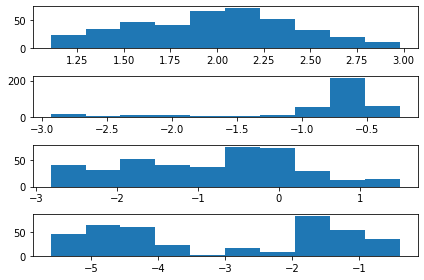

In [84]:
f,a = plt.subplots(len(mu_0))
a = a.ravel()
means = []
stand_dev = []
for idx,ax in enumerate(a):
    means.append(np.mean(testy[idx]))
    stand_dev.append(np.std(testy[idx]))
    ax.hist(testy[idx])

plt.tight_layout()
for i in range(4):
    print("Mean = ",means[i],end=', ')
    print("STD DEV = ",stand_dev[i],end=', ')
    print("Tue Value = ",m_t[i],end=', ')
    print("Diff = ",np.abs(means[i]-m_t[i]))

### Problem ###
 How close are you to 'truth'?
 - I was not very close to the truth on all 4 variable but I seemed to be close on 2 vars with each run.

Consider the following question: would it be better to double the size of the data set, or halve the errors in the data?
 - It seems to be better to lower the error in the data